# Ribbon Invariance

## Intro
* **Date**: 1/5/2021
* **What**: This is the same architecture as in the last experiment (smooth collaborative invariance), but this time, the data I'm training the network on is much simpler.  I'm basically passing a stream of digits (ribbon) in front the plane of view.  I think this should hopefully be an easier dataset for the network to comprehend.
* **Why**: The ribbon is a much simpler dataset than the random traversals over the tapestry of mnist digits.  I think this should hopefully allow my network to start understanding structure a bit better.
* **Hopes**: I'm not actually sure what to expect, but this dataset should be more comprehendable by my network.  I guess I hope the invariant representations this network learns will be better than before.
* **Limitations**: Again, not really sure.  We'll see!

## Code

In [2]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

r_l = 1000 # Length of the ribbon
m_sl = 28 # Side length of each images

r_s = 0 # Starting index of the ribbon

ribbon = np.zeros((m_sl, r_l * m_sl))

for x in range(r_l):
    ribbon[:, m_sl * x : m_sl * (x + 1)] = x_tr[x + r_s]

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

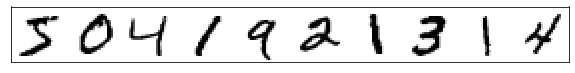

In [11]:
plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(ribbon[:, :m_sl * 10], cmap='gray_r')
plt.show()

Cool. Let's make the animation.

In [14]:
img_count = 100_000
imgs = []

del_t = 1

for i in range((r_l - 1) * m_sl):    
    imgs.append(ribbon[:, i : i + m_sl])
    
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, m_sl ** 2)
gp_data = cp.asarray(ts_data)

<IPython.core.display.Javascript object>


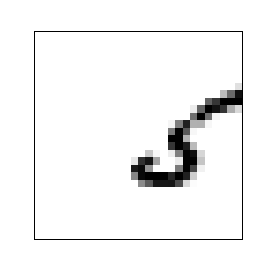

In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(3, 3))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

Dope!

## Analysis Dialog

Alright fam, let's see how the network handles this bad boi.

<IPython.core.display.Javascript object>


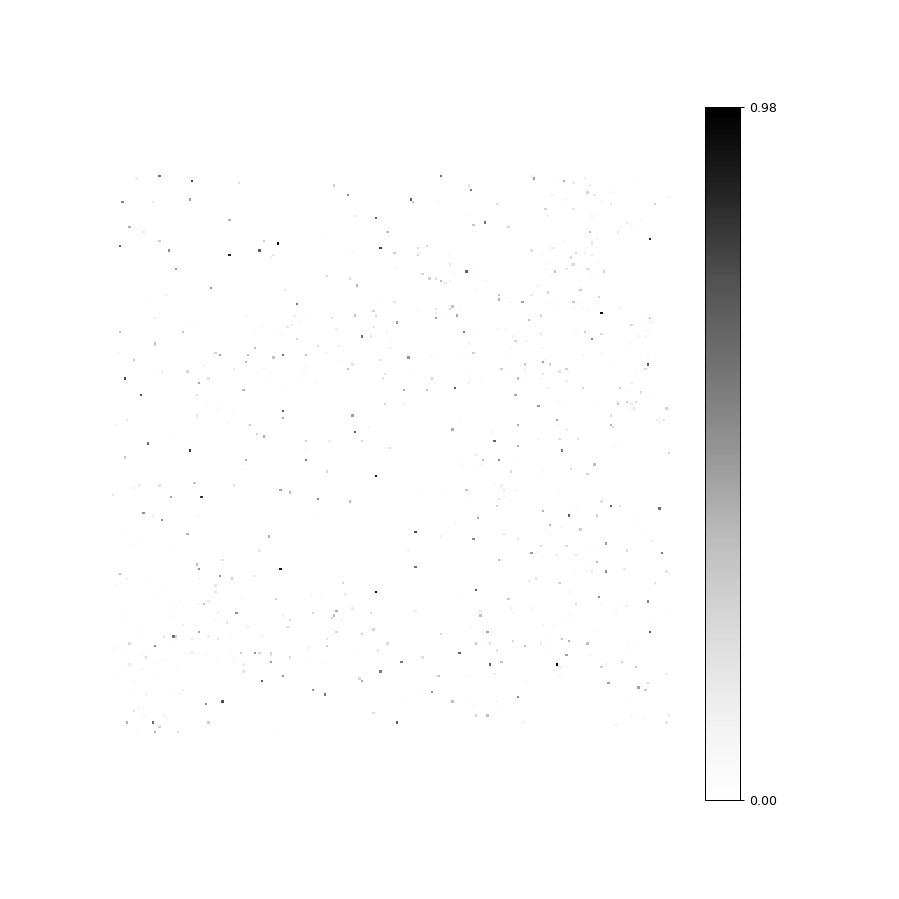

100%|██████████| 10000/10000 [00:08<00:00, 1188.26it/s]


In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = m_sl ** 2

n_w = 6 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.03

# Invariant Layer
Ix = 8
Iy = 8
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 0.5
zeta = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r

        iw += iw * io * (e / mod_r).T * zeta

    if (ep // 2) % 2:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, m_sl, fig)

<IPython.core.display.Javascript object>


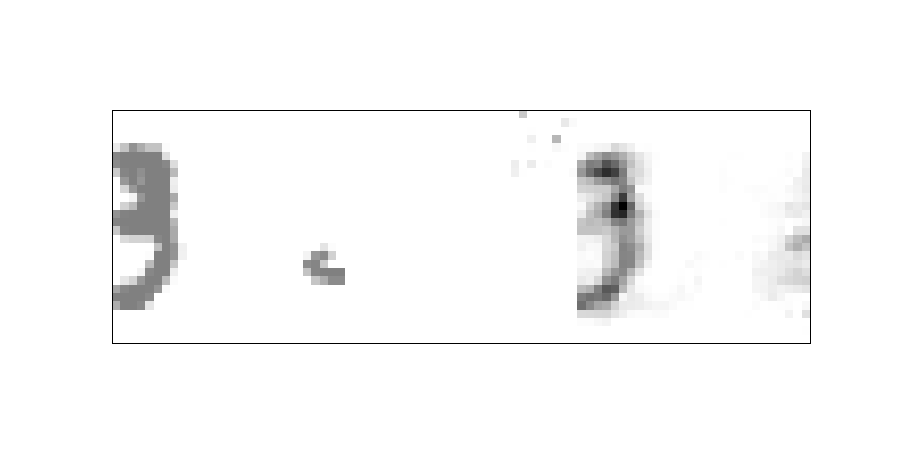

100%|██████████| 500/500 [00:01<00:00, 413.69it/s]


In [20]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((28, 84))
    
    glee = 8
    
    mini_tap[:, :28] = v.reshape(28, 28)
    mini_tap[:glee, 56 - glee:56] = io.reshape(glee, glee)
    mini_tap[:, -28:] = r.reshape(28, 28)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


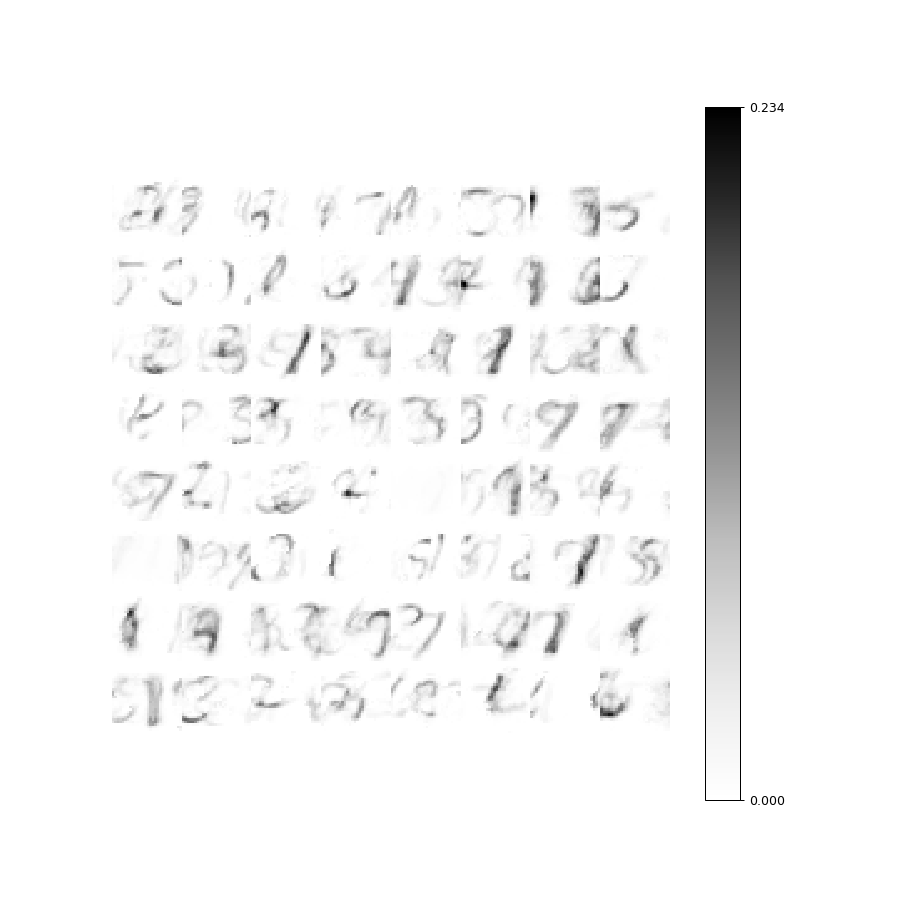

In [22]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 28, fig)

<IPython.core.display.Javascript object>


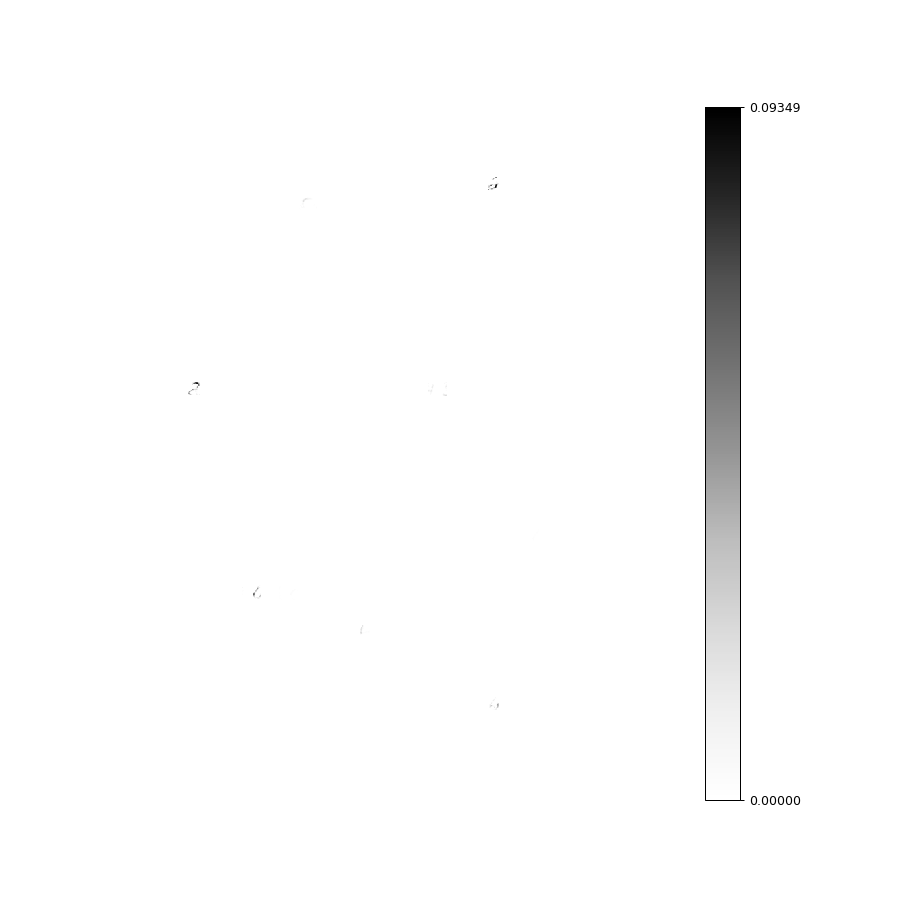

In [27]:
fig = plt.figure(figsize=(10,10))
draw_weights((sw * iw[0].reshape(-1, 1)).get(), Kx, Ky, m_sl, fig)

Yikes, this doesn't really look good, now does it 

<IPython.core.display.Javascript object>


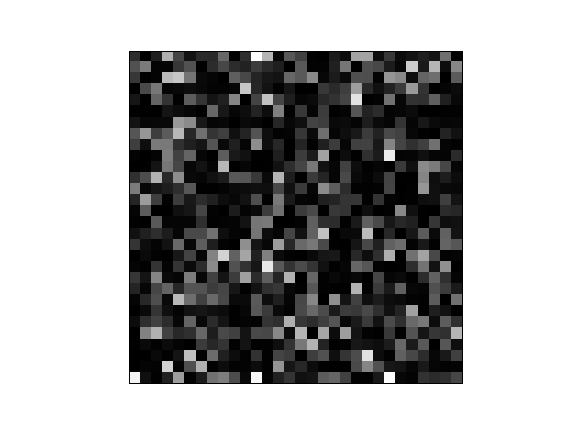

In [28]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray")

Wow.  So much of the sparse layer was missed.  I'm going to try this with 400 sparse neurons, see if it's any better.

This is straight-up bad.

<IPython.core.display.Javascript object>


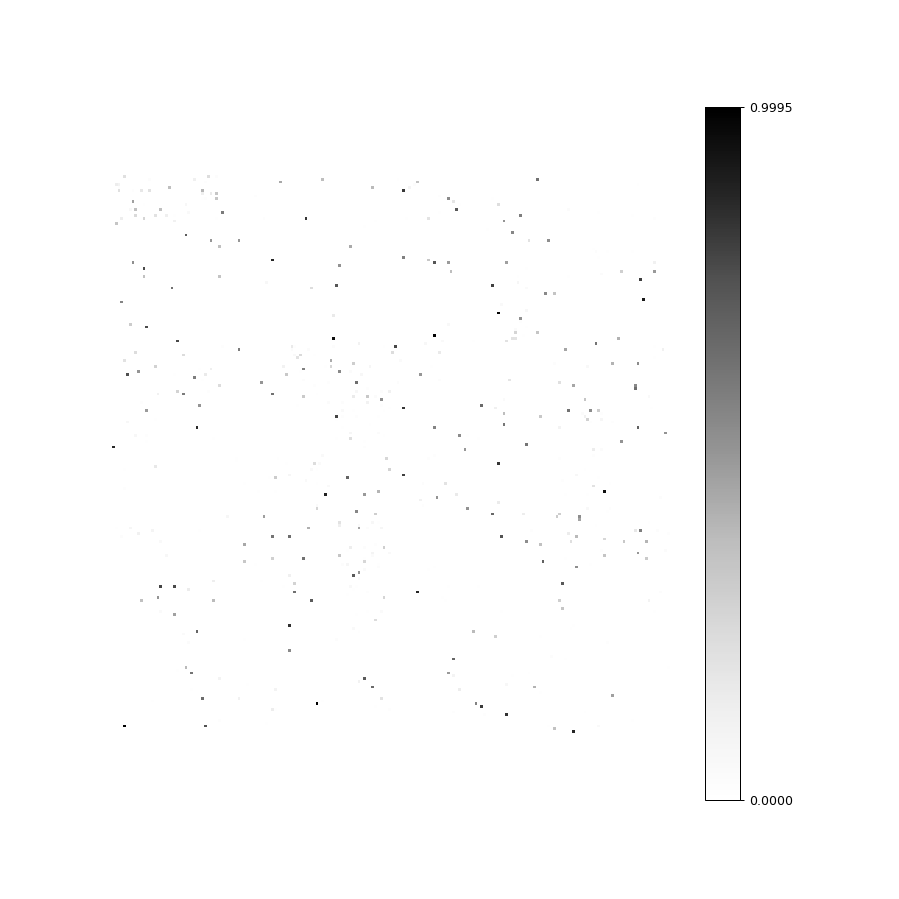

100%|██████████| 10000/10000 [00:08<00:00, 1190.51it/s]


In [29]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000
prec = 1e-10

# Sparse Layer
Kx = 20
Ky = 20
sN = Kx * Ky
m_len = m_sl ** 2

n_w = 10 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.01

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 0.5
zeta = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r

        iw += iw * io * (e / mod_r).T * zeta

    if (ep // 2) % 2:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, m_sl, fig)

<IPython.core.display.Javascript object>


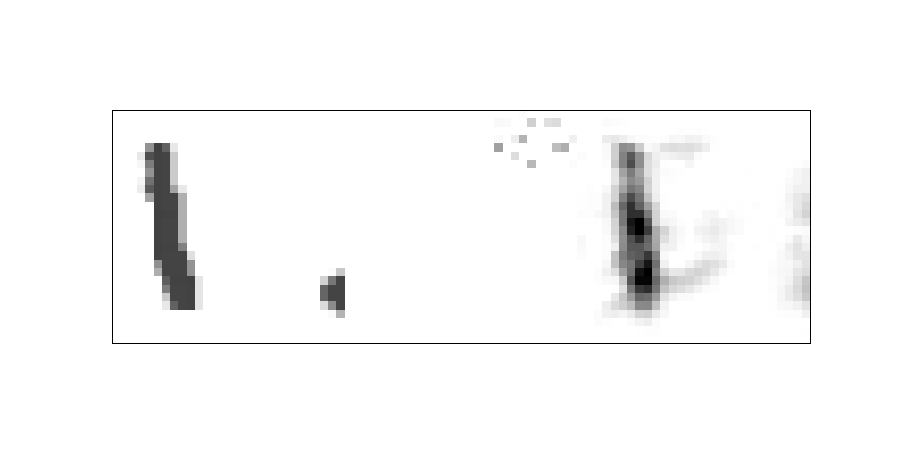

100%|██████████| 500/500 [00:00<00:00, 521.42it/s]


In [32]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((28, 84))
    
    glee = 10
    
    mini_tap[:, :28] = v.reshape(28, 28)
    mini_tap[:glee, 56 - glee:56] = io.reshape(glee, glee)
    mini_tap[:, -28:] = r.reshape(28, 28)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=200)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


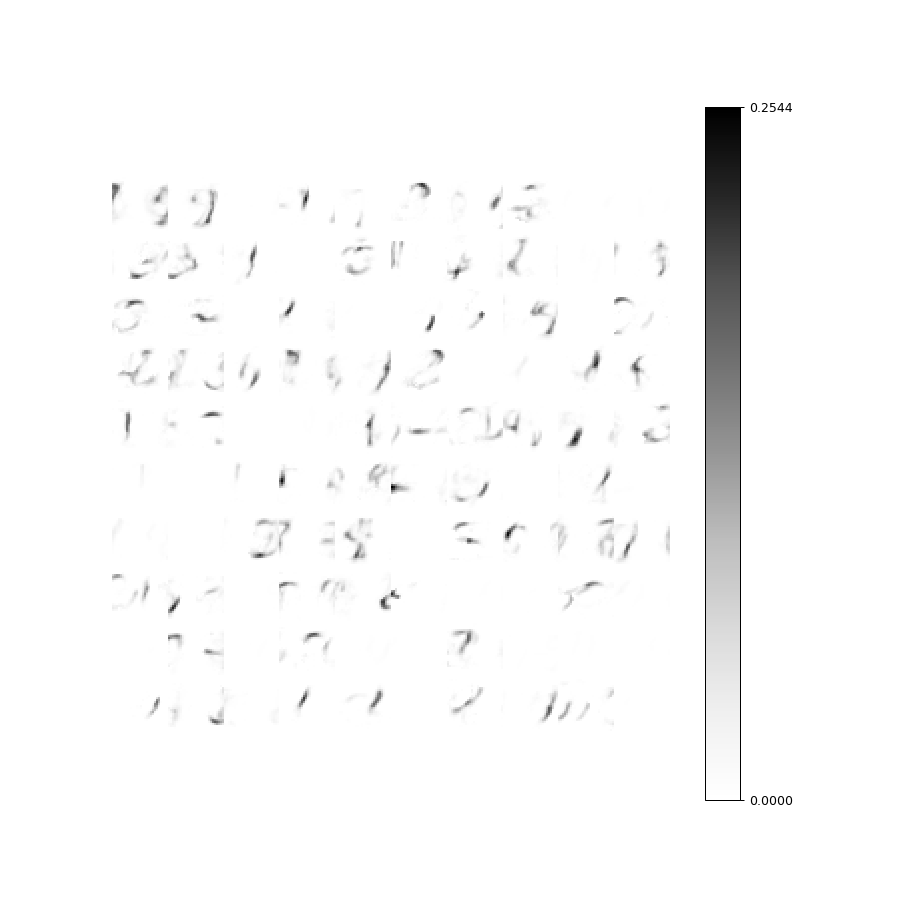

In [33]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 28, fig)

<IPython.core.display.Javascript object>


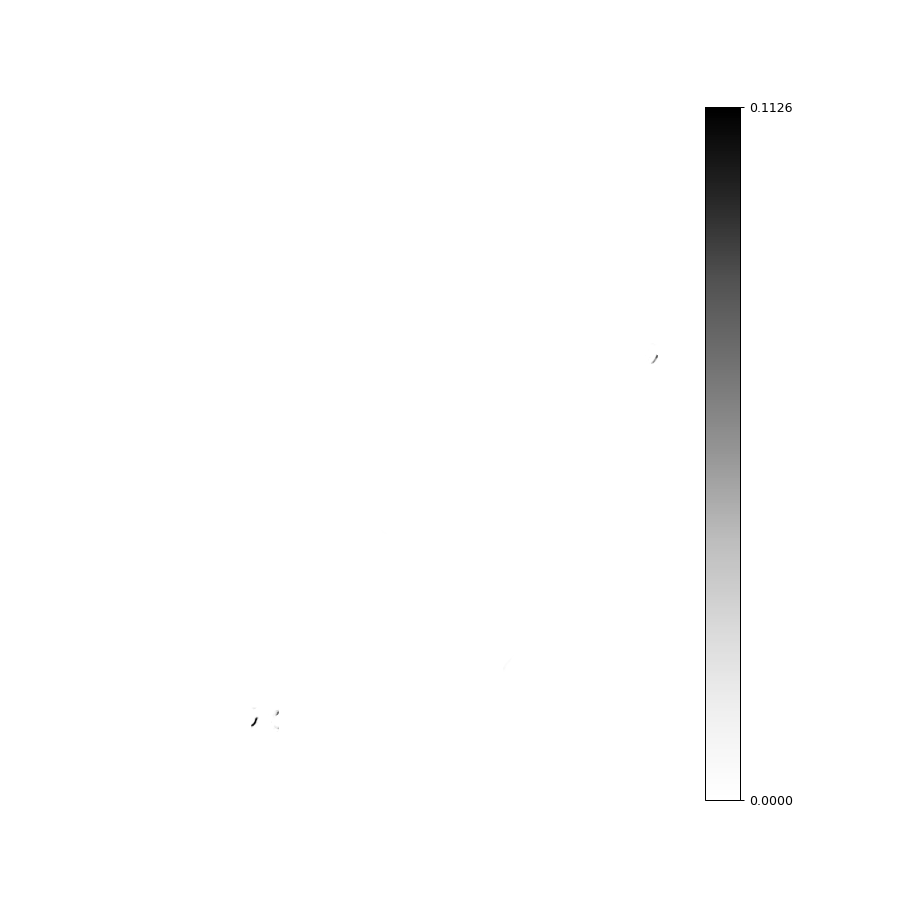

In [35]:
fig = plt.figure(figsize=(10,10))
draw_weights((sw * iw[98].reshape(-1, 1)).get(), Kx, Ky, m_sl, fig)

<IPython.core.display.Javascript object>


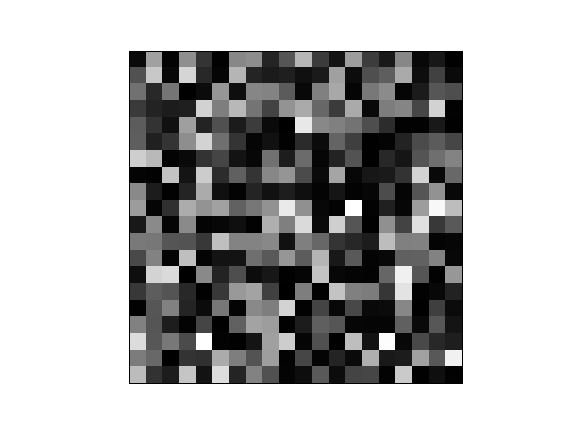

In [36]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray")

This isn't looking great.  Ok, I'm going to train on 900 sparse neurons, 10 winners.

<IPython.core.display.Javascript object>


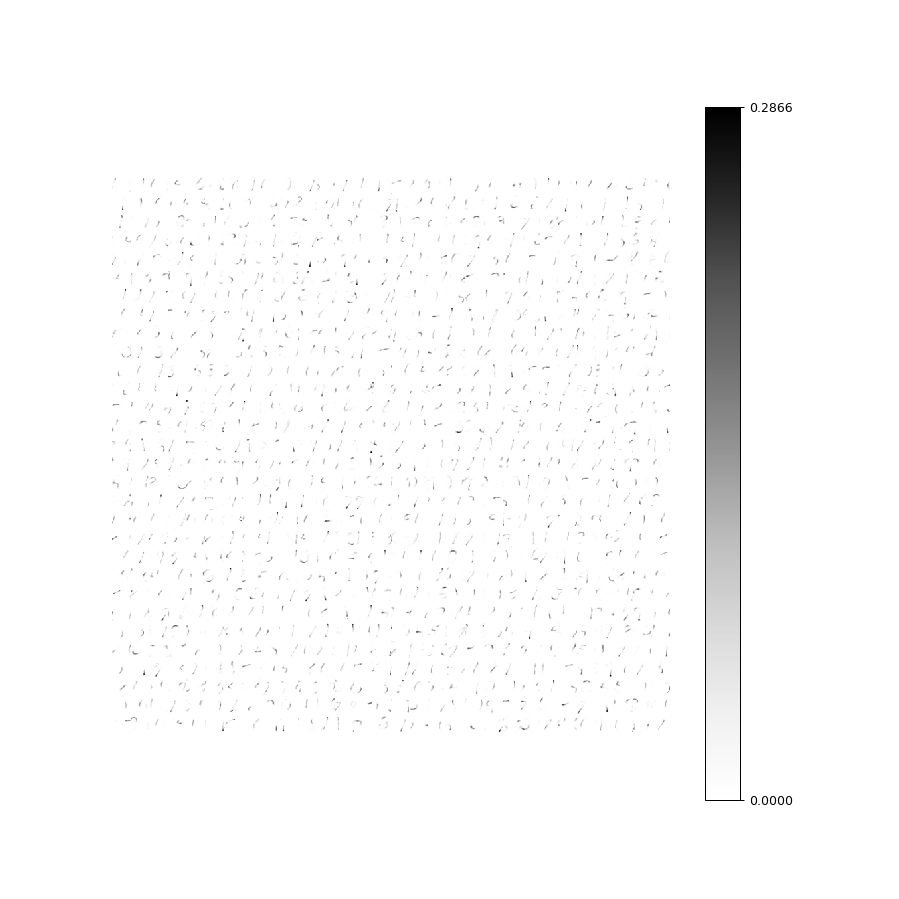

100%|██████████| 10000/10000 [00:08<00:00, 1125.21it/s]


In [37]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = m_sl ** 2

n_w = 10 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.01

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 0.5
zeta = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r

        iw += iw * io * (e / mod_r).T * zeta

    if (ep // 4) % 2:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, m_sl, fig)

<IPython.core.display.Javascript object>


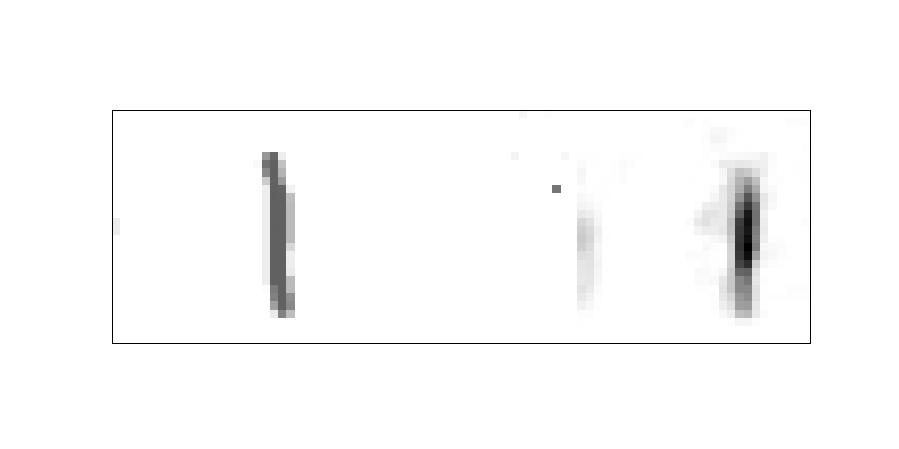

100%|██████████| 500/500 [00:01<00:00, 404.10it/s]


In [39]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((28, 84))
    
    glee = 10
    
    mini_tap[:, :28] = v.reshape(28, 28)
    mini_tap[:glee, 56 - glee:56] = io_pert.reshape(glee, glee)
    mini_tap[:, -28:] = r.reshape(28, 28)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=200)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


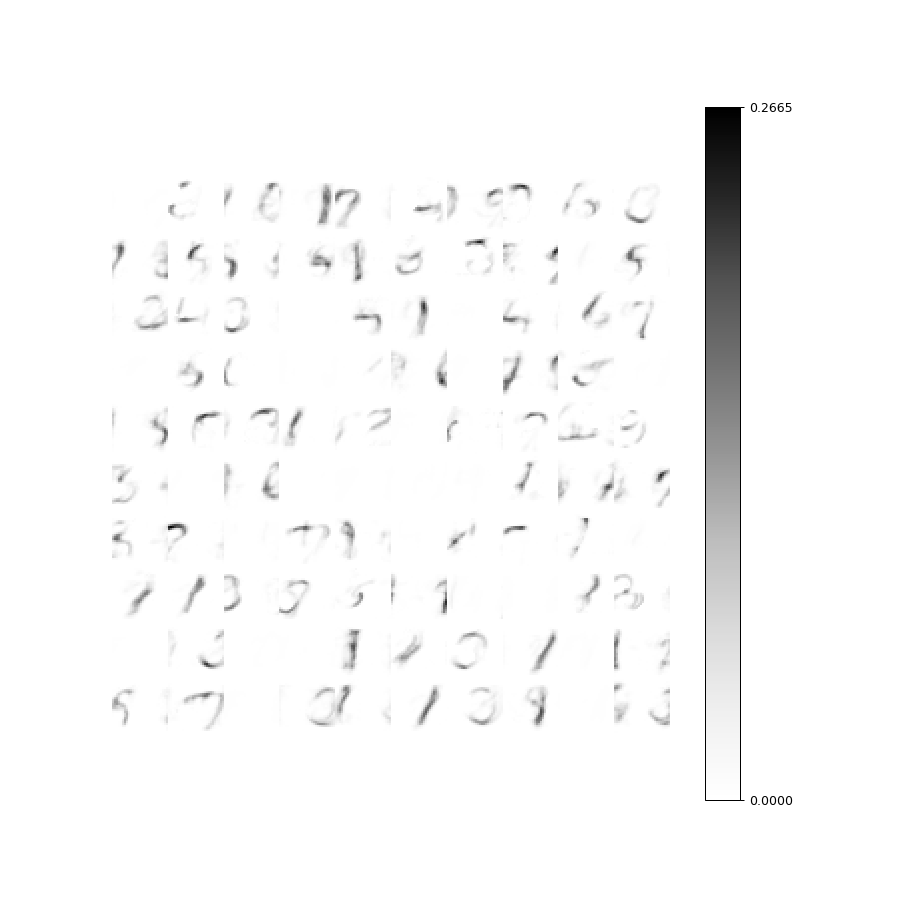

In [40]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 28, fig)

<IPython.core.display.Javascript object>


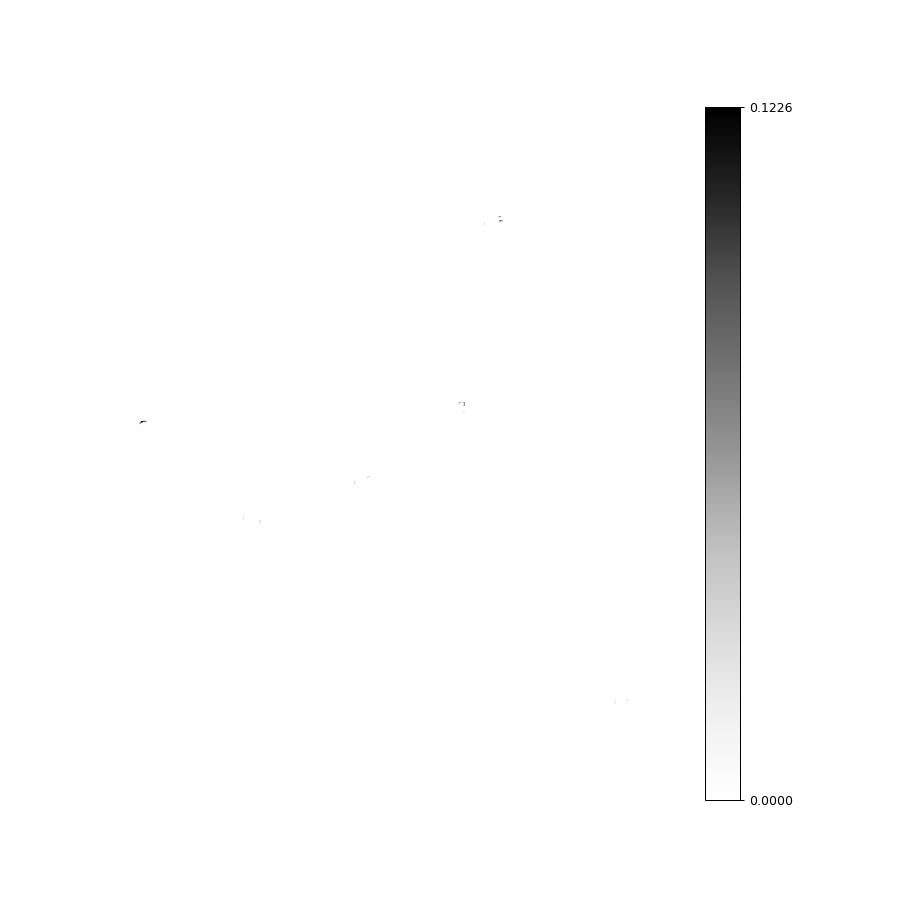

In [43]:
fig = plt.figure(figsize=(10,10))
draw_weights((sw * iw[42].reshape(-1, 1)).get(), Kx, Ky, m_sl, fig)

<IPython.core.display.Javascript object>


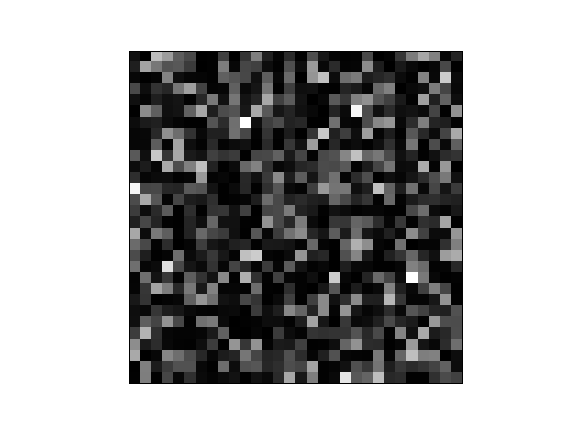

In [44]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray")

I'm going to try a smaller alpha.

<IPython.core.display.Javascript object>


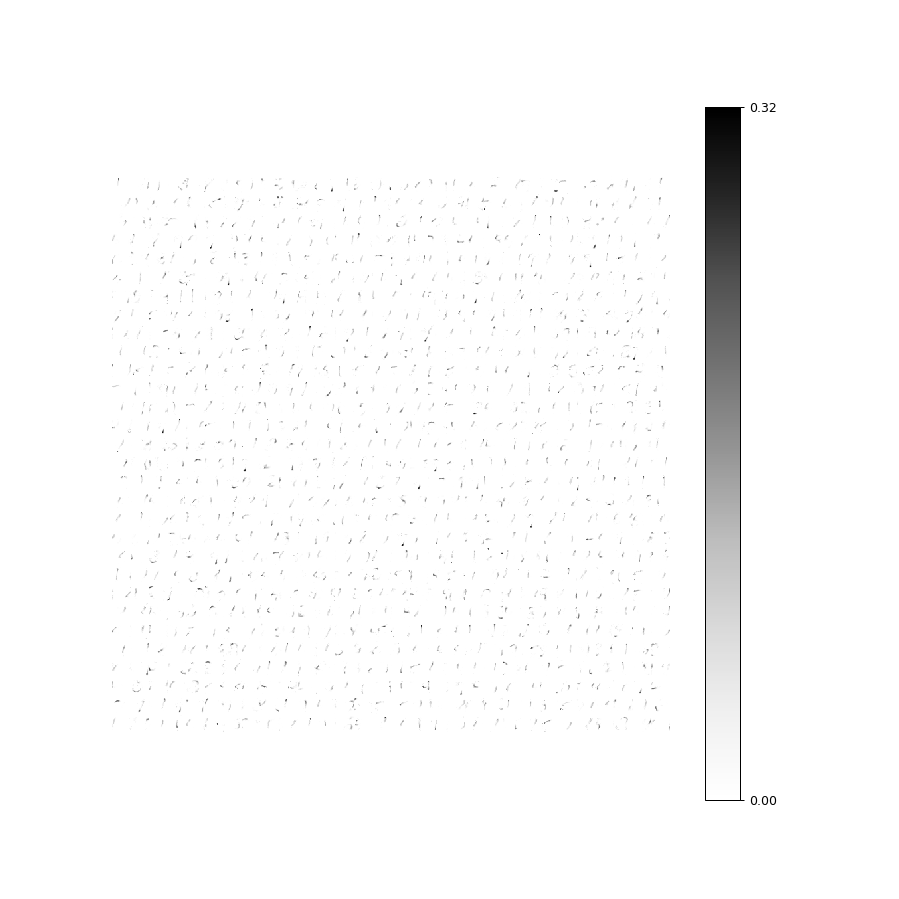

100%|██████████| 10000/10000 [00:08<00:00, 1127.46it/s]


In [46]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = m_sl ** 2

n_w = 10 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.04

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 7
zeta = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r

        iw += iw * io * (e / mod_r).T * zeta

    if (ep // 4) % 2:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, m_sl, fig)

<IPython.core.display.Javascript object>


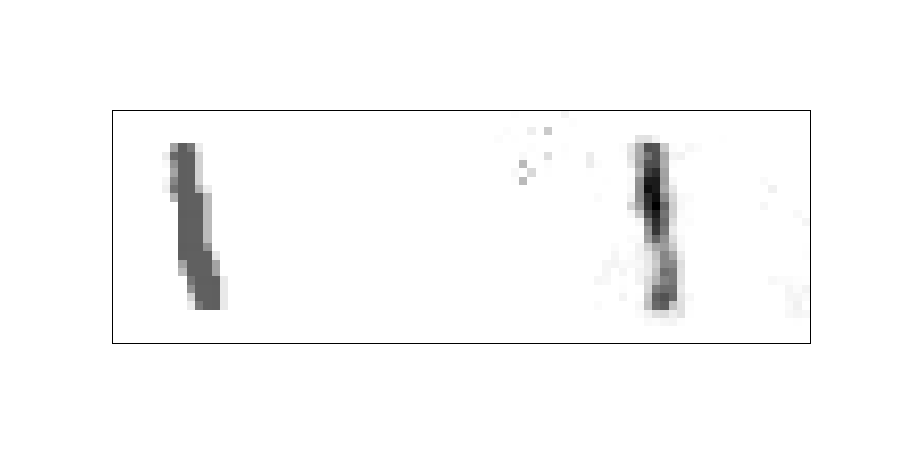

100%|██████████| 500/500 [00:01<00:00, 417.61it/s]


In [48]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((28, 84))
    
    glee = 10
    
    mini_tap[:, :28] = v.reshape(28, 28)
    mini_tap[:glee, 56 - glee:56] = io.reshape(glee, glee)
    mini_tap[:, -28:] = r.reshape(28, 28)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=200)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


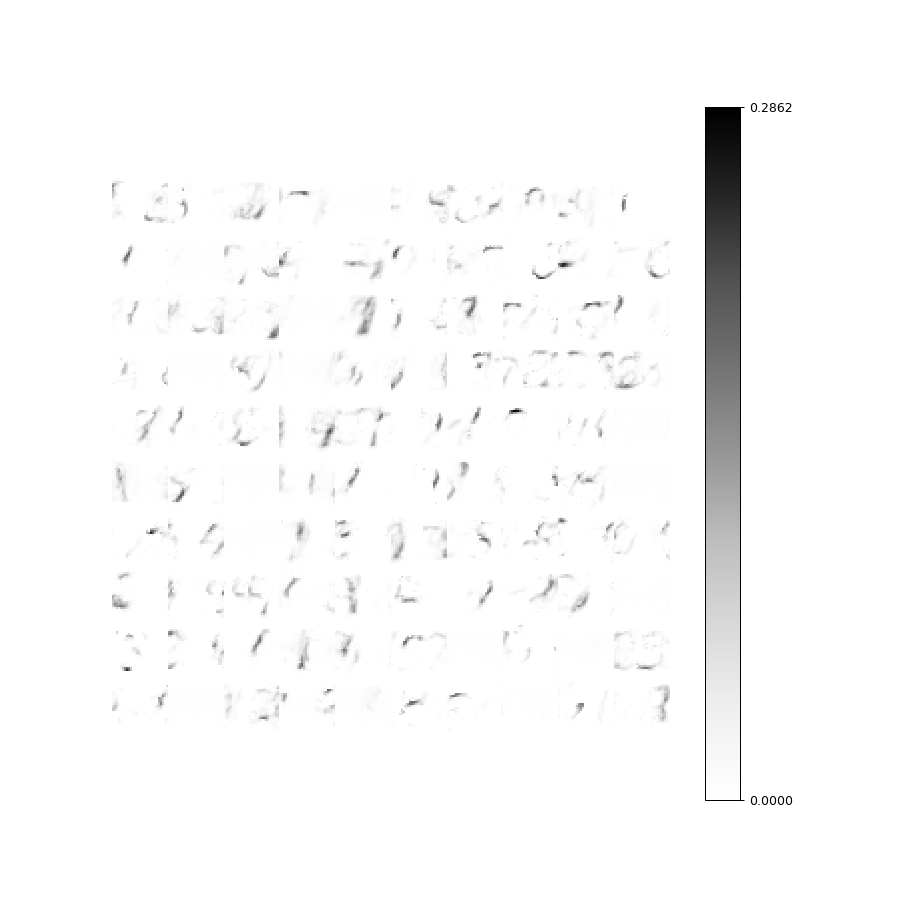

In [49]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 28, fig)

<IPython.core.display.Javascript object>


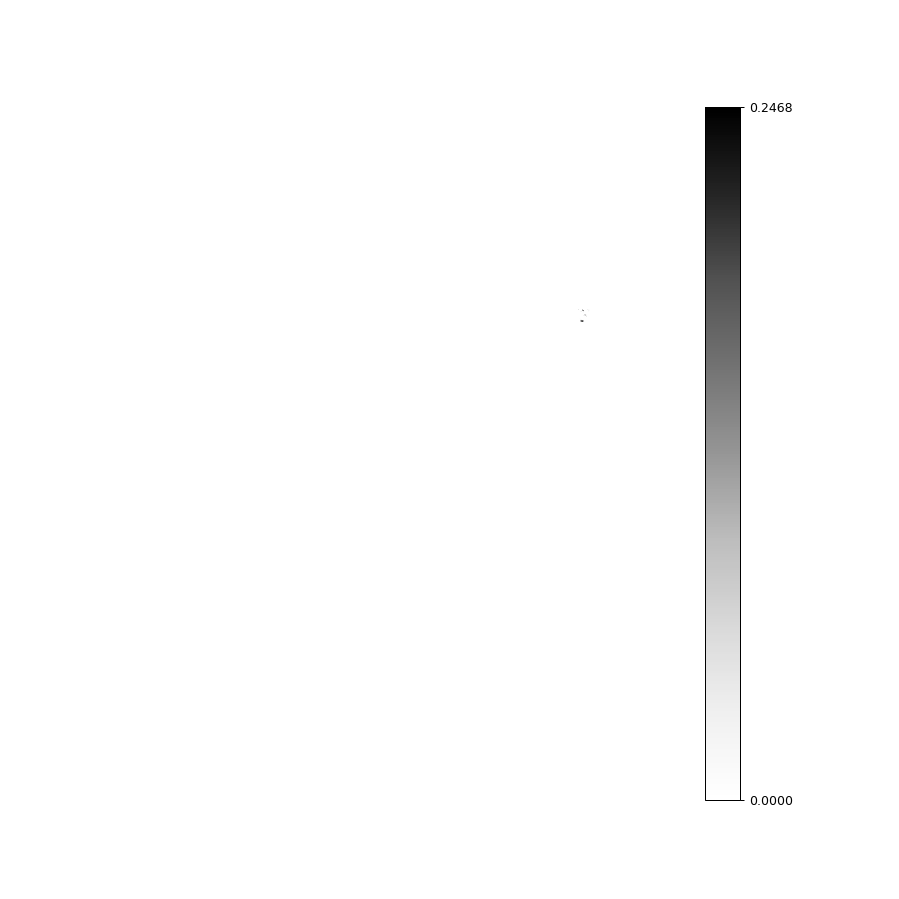

In [54]:
fig = plt.figure(figsize=(10,10))
draw_weights((sw * iw[80].reshape(-1, 1)).get(), Kx, Ky, m_sl, fig)

<IPython.core.display.Javascript object>


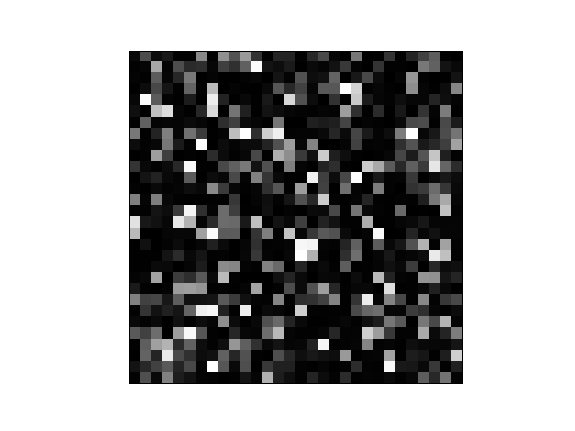

In [51]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray")

I'm wrapping this up here and now.

## Conclusions

This strategy of cultivating invariance is just straight-up not working.  

I'm not a huge fan, I guess that's the easy way of saying it.  But I mean it's only two days, and there's no way the universe would let me figure out invariance in that short of a span of time.  I guess I can probably expect to spend about a month before I have a good understanding of how to do this.  

So, what am I seeing?  I'm seeing sparse neurons ignored, I'm seeing non-correlated neurons being matched together.

I actually had another idea.  I'm going to ema with no learning occuring on "off neurons." Let's see how that works.

<IPython.core.display.Javascript object>


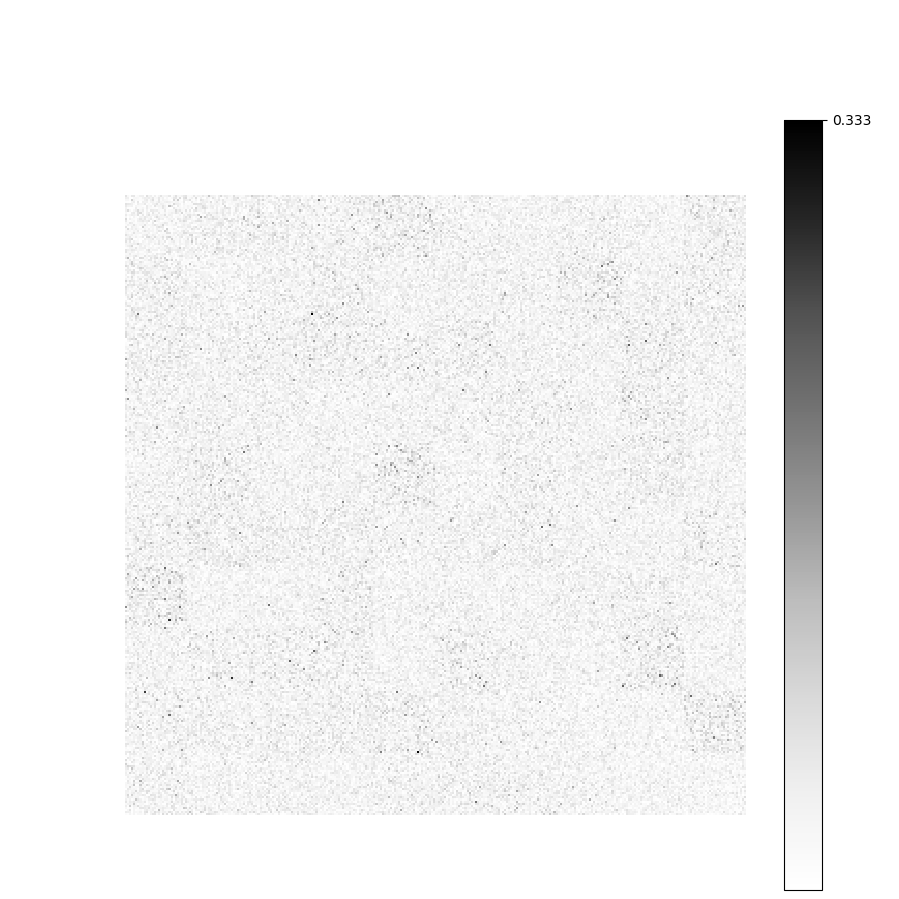

 75%|███████▌  | 7519/10000 [00:07<00:02, 1005.08it/s]


KeyboardInterrupt: 

In [58]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = m_sl ** 2

n_w = 10 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.04

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 7
zeta = 1


for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = cp.where(so > 0, so - r, 0)

        iw += iw * io * (e / mod_r).T * zeta

    if not (ep // 4) % 2:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, m_sl, fig)

<IPython.core.display.Javascript object>


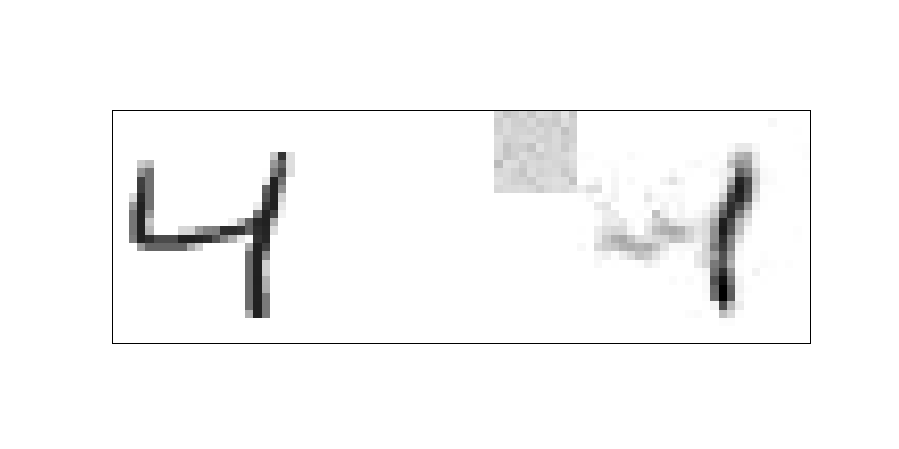

100%|██████████| 500/500 [00:01<00:00, 361.16it/s]


In [59]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((28, 84))
    
    glee = 10
    
    mini_tap[:, :28] = v.reshape(28, 28)
    mini_tap[:glee, 56 - glee:56] = io.reshape(glee, glee)
    mini_tap[:, -28:] = r.reshape(28, 28)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=200)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


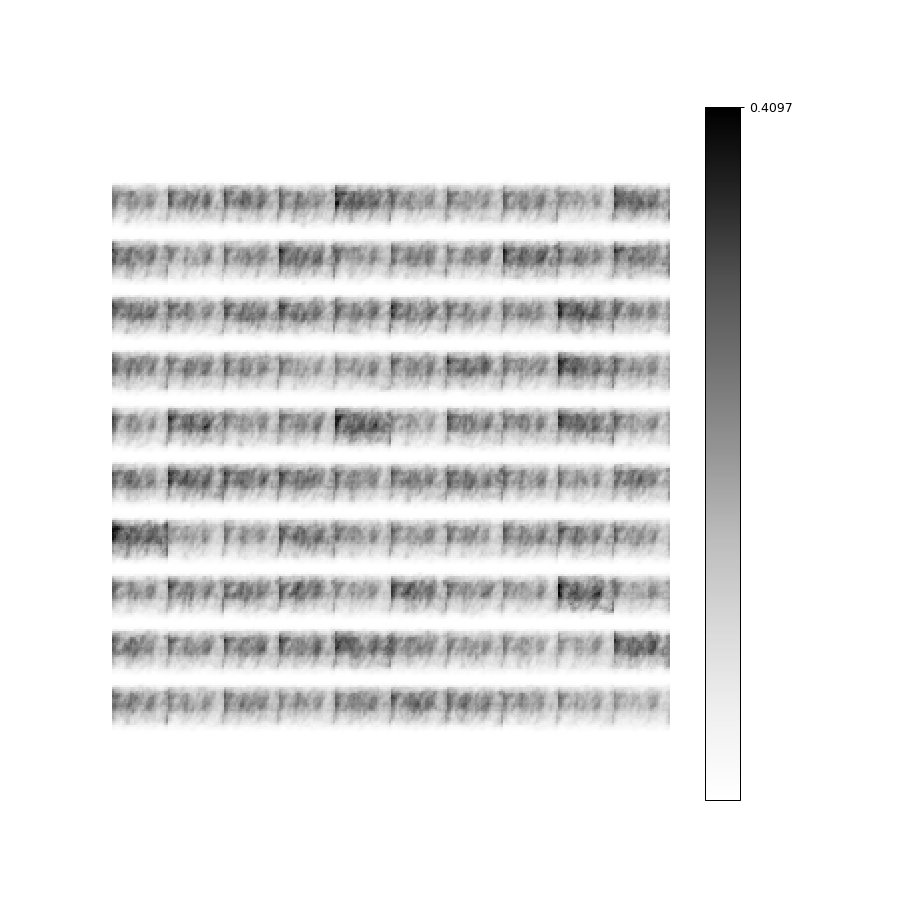

In [60]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 28, fig)

## Conclusions

Yeah, I hate everything.  Everything is broken, and I need to figure out how to fix it.

## Next steps

Figure out how to get performance like Yubei's network.  I need to think.